In [80]:
#Pandas
import pandas as pd

#SQL Alchemy
from sqlalchemy import create_engine, func, desc
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
import datetime as dt
from flask import Flask, jsonify

#Matplotlib
import matplotlib.pyplot as plt

database_path = "/Users/varunvinodh/Downloads/Instructions 3/Resources/hawaii.sqlite"

In [49]:
#Create engine
engine = create_engine(f"sqlite:///{database_path}")
conn = engine.connect()

In [50]:
#Query all records in the database
station_data = pd.read_sql("SELECT * FROM station", conn)
measurement_data = pd.read_sql("SELECT * FROM measurement", conn)

In [51]:
#Sample
station_data.head

<bound method NDFrame.head of    id      station                                    name  latitude  \
0   1  USC00519397                    WAIKIKI 717.2, HI US  21.27160   
1   2  USC00513117                    KANEOHE 838.1, HI US  21.42340   
2   3  USC00514830  KUALOA RANCH HEADQUARTERS 886.9, HI US  21.52130   
3   4  USC00517948                       PEARL CITY, HI US  21.39340   
4   5  USC00518838              UPPER WAHIAWA 874.3, HI US  21.49920   
5   6  USC00519523      WAIMANALO EXPERIMENTAL FARM, HI US  21.33556   
6   7  USC00519281                     WAIHEE 837.5, HI US  21.45167   
7   8  USC00511918       HONOLULU OBSERVATORY 702.2, HI US  21.31520   
8   9  USC00516128            MANOA LYON ARBO 785.2, HI US  21.33310   

   longitude  elevation  
0 -157.81680        3.0  
1 -157.80150       14.6  
2 -157.83740        7.0  
3 -157.97510       11.9  
4 -158.01110      306.6  
5 -157.71139       19.5  
6 -157.84889       32.9  
7 -157.99920        0.9  
8 -157.80250   

In [52]:
#Sample
measurement_data.head

<bound method NDFrame.head of           id      station        date  prcp  tobs
0          1  USC00519397  2010-01-01  0.08  65.0
1          2  USC00519397  2010-01-02  0.00  63.0
2          3  USC00519397  2010-01-03  0.00  74.0
3          4  USC00519397  2010-01-04  0.00  76.0
4          5  USC00519397  2010-01-06   NaN  73.0
...      ...          ...         ...   ...   ...
19545  19546  USC00516128  2017-08-19  0.09  71.0
19546  19547  USC00516128  2017-08-20   NaN  78.0
19547  19548  USC00516128  2017-08-21  0.56  76.0
19548  19549  USC00516128  2017-08-22  0.50  76.0
19549  19550  USC00516128  2017-08-23  0.45  76.0

[19550 rows x 5 columns]>

In [53]:
# execute the SQL query and retrieve the number of stations in the dataset
no_of_stations = engine.execute("SELECT COUNT(DISTINCT id) AS num_stations FROM station").fetchall()

# print the result
print(f"The number of stations in the dataset is {no_of_stations[0][0]}")

The number of stations in the dataset is 9


In [54]:
# execute the SQL query to list the stations and observation counts in descending order and finds the most active station
results = engine.execute('SELECT station.station, station.name, COUNT(measurement.station) AS num_observations \
                          FROM station \
                          JOIN measurement \
                          ON station.station = measurement.station \
                          GROUP BY station.station, station.name \
                          ORDER BY num_observations DESC;').fetchall()

# print the results
for row in results:
    print(row)

('USC00519281', 'WAIHEE 837.5, HI US', 2772)
('USC00519397', 'WAIKIKI 717.2, HI US', 2724)
('USC00513117', 'KANEOHE 838.1, HI US', 2709)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669)
('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202)
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979)
('USC00517948', 'PEARL CITY, HI US', 1372)
('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)


In [81]:
Base = automap_base()
Base.prepare(engine, reflect=True)

StationData = Base.classes.station
MeasurementData = Base.classes.measurement

session = Session(engine)

active_station = session.query(MeasurementData.station, func.count(MeasurementData.station)).\
    group_by(MeasurementData.station).\
    order_by(func.count(MeasurementData.station).desc()).first()[0]

temp_stats = session.query(func.min(MeasurementData.tobs), func.max(MeasurementData.tobs), func.avg(MeasurementData.tobs)).\
    filter(MeasurementData.station == active_station).all()

session.close()

print(f"Min temp: {temp_stats[1]}, Max temp: {temp_stats[1]}, Avg temp: {temp_stats[2]}")

IndexError: list index out of range

In [59]:

# reflect the database tables
Base = automap_base()
Base.prepare(engine, reflect=True)

# create references to the tables
Station = Base.classes.station
Measurement = Base.classes.measurement



In [61]:
# query to find the most active station
most_active_station = (
    session.query(Measurement.station)
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .first()
)[0]

# query to find min, max, and average temperatures for the most active station
temp_stats = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs),
    )
    .filter(Measurement.station == most_active_station)
    .all()
)[0]

print(f"Min temp: {temp_stats[0]}, Max temp: {temp_stats[1]}, Avg temp: {temp_stats[2]}")


Min temp: 54.0, Max temp: 85.0, Avg temp: 71.66378066378067


In [64]:
# calculate the date 1 year ago from the last data point in the database
latest_date = session.query(func.max(Measurement.date)).scalar()
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")
one_year_ago = latest_date - dt.timedelta(days=365)

# get the station with the greatest number of observations
station_obs_counts = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station = station_obs_counts[0][0]

# query the previous 12 months of temperature observation data for the most active station
tobs_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# print the tobs data
print(tobs_data)

[('2016-08-24', 77.0), ('2016-08-25', 80.0), ('2016-08-26', 80.0), ('2016-08-27', 75.0), ('2016-08-28', 73.0), ('2016-08-29', 78.0), ('2016-08-30', 77.0), ('2016-08-31', 78.0), ('2016-09-01', 80.0), ('2016-09-02', 80.0), ('2016-09-03', 78.0), ('2016-09-04', 78.0), ('2016-09-05', 78.0), ('2016-09-06', 73.0), ('2016-09-07', 74.0), ('2016-09-08', 80.0), ('2016-09-09', 79.0), ('2016-09-10', 77.0), ('2016-09-11', 80.0), ('2016-09-12', 76.0), ('2016-09-13', 79.0), ('2016-09-14', 75.0), ('2016-09-15', 79.0), ('2016-09-16', 78.0), ('2016-09-17', 79.0), ('2016-09-18', 78.0), ('2016-09-19', 78.0), ('2016-09-20', 76.0), ('2016-09-21', 74.0), ('2016-09-22', 77.0), ('2016-09-23', 78.0), ('2016-09-24', 79.0), ('2016-09-25', 79.0), ('2016-09-26', 77.0), ('2016-09-27', 80.0), ('2016-09-28', 78.0), ('2016-09-29', 78.0), ('2016-09-30', 78.0), ('2016-10-01', 77.0), ('2016-10-02', 79.0), ('2016-10-03', 79.0), ('2016-10-04', 79.0), ('2016-10-05', 79.0), ('2016-10-06', 75.0), ('2016-10-07', 76.0), ('2016-10

In [67]:
# create pandas dataframe from the tobs data
tobs_df = pd.DataFrame(tobs_data, columns=['date', 'tobs'])

# print the dataframe
print(tobs_df.head())


         date  tobs
0  2016-08-24  77.0
1  2016-08-25  80.0
2  2016-08-26  80.0
3  2016-08-27  75.0
4  2016-08-28  73.0


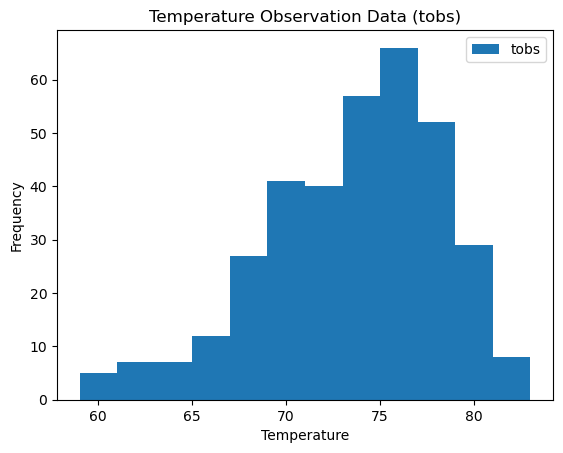

In [70]:
# Set the date column as the DataFrame index
tobs_df.set_index('date', inplace=True)

# Use the pandas built-in plot.hist() method to create the histogram
tobs_df.plot.hist(bins=12)

# Set the plot title and x/y-axis labels
plt.title("Temperature Observation Data (tobs)")
plt.xlabel("Temperature")
plt.ylabel("Frequency")

# Show the plot
plt.show()

In [71]:
# find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# print the most recent date
print(most_recent_date)

2017-08-23


In [76]:
#Query that collects only the date and precipitation for the last year of data
last_year_precip = session.query(Measurement.date, Measurement.prcp)\
    .filter(Measurement.date > (dt.datetime.strptime(session.query(func.max(Measurement.date)).scalar(), '%Y-%m-%d') - dt.timedelta(days=365)))\
    .all()
print(last_year_precip)

[('2016-08-24', 0.08), ('2016-08-25', 0.08), ('2016-08-26', 0.0), ('2016-08-27', 0.0), ('2016-08-28', 0.01), ('2016-08-29', 0.0), ('2016-08-30', 0.0), ('2016-08-31', 0.13), ('2016-09-01', 0.0), ('2016-09-02', 0.0), ('2016-09-03', 0.0), ('2016-09-04', 0.03), ('2016-09-05', None), ('2016-09-06', None), ('2016-09-07', 0.05), ('2016-09-08', 0.0), ('2016-09-09', 0.03), ('2016-09-10', 0.0), ('2016-09-11', 0.05), ('2016-09-12', 0.0), ('2016-09-13', 0.02), ('2016-09-14', 1.32), ('2016-09-15', 0.42), ('2016-09-16', 0.06), ('2016-09-17', 0.05), ('2016-09-18', 0.0), ('2016-09-19', 0.0), ('2016-09-20', 0.0), ('2016-09-21', 0.0), ('2016-09-22', 0.02), ('2016-09-23', 0.0), ('2016-09-24', 0.0), ('2016-09-25', 0.0), ('2016-09-26', 0.06), ('2016-09-27', 0.02), ('2016-09-28', 0.0), ('2016-09-29', 0.0), ('2016-09-30', 0.0), ('2016-10-01', 0.0), ('2016-10-02', 0.0), ('2016-10-03', 0.0), ('2016-10-04', 0.0), ('2016-10-05', 0.0), ('2016-10-06', 0.0), ('2016-10-07', 0.0), ('2016-10-08', 0.0), ('2016-10-09', 

In [77]:

# Save the query results to a Pandas DataFrame
df = pd.DataFrame(last_year_precip, columns=['date', 'precipitation'])

# Set the index to the date column and sort the dataframe by date
df.set_index('date', inplace=True)
df.sort_index(inplace=True)

# Display the dataframe
print(df.head())

            precipitation
date                     
2016-08-24           0.08
2016-08-24            NaN
2016-08-24           2.15
2016-08-24           2.28
2016-08-24           2.15


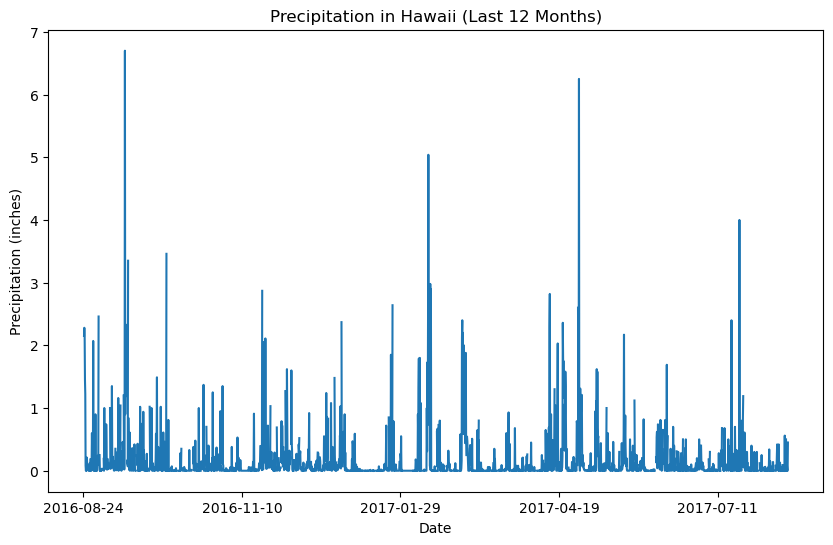

In [79]:

# plot the precipitation data
df.plot(y='precipitation', figsize=(10,6), legend=False)
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation in Hawaii (Last 12 Months)")
plt.show()